In [1]:
import glob
import random 
import os 
import subprocess
from collections import defaultdict

# Astropy Loading
import astropy
from astropy.io import fits
from astropy.table import Table, hstack
from astropy.utils.metadata import MergeConflictWarning

# Scientific Python
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.simplefilter('ignore', MergeConflictWarning)
# List all FITS files
# Get the repo root (assumes script is inside STARDUSTAI/)
repo_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip()
base_dir = os.path.join(repo_root, "data/full/")
file_paths = glob.glob(os.path.join(base_dir, "*/*.fits"))

# If no FITS files are found, raise an error
if not file_paths:
    raise ValueError("No FITS files found in 'data/full/'")

# Shuffle the file paths
random.shuffle(file_paths)


In [ ]:
# Custom PyTorch dataset for loading
class FitsDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths  # Store file paths
        self.class_categories = ['STAR', 'GALAXY', 'QSO']
        self.subclass_categories = ['nan', 'Starforming', 'Starburst', 'AGN', 'O', 'OB', 'B6', 'B9', 'A0', 'A0p', 'F2', 'F5', 'F9', 'G0', 'G2', 'G5', 'K1', 'K3', 'K5', 'K7', 'M0V', 'M2V', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'L5.5', 'L9', 'T2', 'Carbon', 'Carbon_lines', 'CarbonWD', 'CV', 'BROADLINE']
        self.plate_quality_tags = {'bad': 0,  'marginal': 1, 'good': 2, 'nan': np.nan}

    def __len__(self):
        return len(self.file_paths)  # Total number of files

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        
        # Read FITS file as Astropy Table
        dat1 = Table.read(file_path, format='fits', hdu=1)
        dat1 = dat1['flux', 'loglam', 'ivar', 'model']
        dat2 = Table.read(file_path, format='fits', hdu=2)
        dat2 = dat2['PLATEQUALITY', 'PLATESN2', 'PLATE', 'TILE', 'MJD', 'FIBERID', 'CLASS', "SUBCLASS", 'Z', 'Z_ERR', 'SN_MEDIAN', 'SN_MEDIAN_ALL', 'ZWARNING' , 'RCHI2']
        data = hstack([dat1, dat2])  # Merge HDUs
        sn_median_values = np.vstack(data['SN_MEDIAN'])  # Shape: (4590, 5)

        # Add new columns for each filter
        data['SN_MEDIAN_UV'] = sn_median_values[:, 0]  # Ultraviolet
        data['SN_MEDIAN_G'] = sn_median_values[:, 1]   # Green
        data['SN_MEDIAN_R'] = sn_median_values[:, 2]   # Red
        data['SN_MEDIAN_NIR'] = sn_median_values[:, 3] # Near-Infrared
        data['SN_MEDIAN_IR'] = sn_median_values[:, 4]  # Infrared

        # Remove the original SN_MEDIAN column if needed
        data.remove_column('SN_MEDIAN')

        # Convert Astropy Table to Pandas DataFrame
        df = data.to_pandas()

        # Map PLATEQUALITY to numerical values and fill NaNs with same value
        df['PLATEQUALITY'] = df['PLATEQUALITY'].astype(str).map(self.plate_quality_tags)
        first_value = df['PLATEQUALITY'].iloc[0]
        df.fillna(value = {'PLATEQUALITY': first_value}, inplace=True)
       

        # one hot encode class
        df['CLASS'] = df['CLASS'].astype(str)
        class_label = df['CLASS'].values[0] 
        class_one_hot = np.zeros(len(self.class_categories))
        class_one_hot[self.class_categories.index(class_label)] = 1

        # one hot encode subclass
        df['SUBCLASS'] = df['SUBCLASS'].astype(str)
        subclass_label = df['SUBCLASS'].values[0]
        if subclass_label not in self.subclass_categories:
            subclass_label = 'nan'
        subclass_one_hot = np.zeros(len(self.subclass_categories))
        subclass_one_hot[self.subclass_categories.index(subclass_label)] = 1

        # Drop class and subclass columns and keep everything else 
        features = df.drop(columns=['CLASS', 'SUBCLASS'])
        features = features.fillna(0) 
        features = features.astype(np.float32) 

        features_tensor = torch.tensor(features.values, dtype=torch.float32)
        class_label_tensor = torch.tensor(class_one_hot, dtype=torch.long)
        subclass_label_tensor = torch.tensor(subclass_one_hot, dtype=torch.long)

        return features_tensor, class_label_tensor, subclass_label_tensor  

In [ ]:
dataset = FitsDataset(file_paths)

In [3]:
def data_stats(file_paths):
    """
    Process a list of FITS files and print statistics related to class 
    distribution, subclass distribution, and ZWARNING.

    Args:
        file_paths (list of str): A list of file paths to the FITS files.

    Returns:
        dict: A dictionary containing the redshifts, sn_median_all, and 
              zwarning class counts.
    """
    class_counts = defaultdict(int)
    subclass_counts = defaultdict(int)
    zwarning_zero = 0
    total_objects = 0
    
    # New containers for additional analysis
    zwarning_class_counts = defaultdict(int)
    redshifts = defaultdict(list)
    sn_median_all = defaultdict(list)

    for file_path in file_paths:
        with fits.open(file_path) as hdul:
            if len(hdul) <= 2:
                print(f"Skipping {file_path}: HDU 2 does not exist.")
                continue
            hdu2 = hdul[2].data
            
            # Original processing (first object)
            main_class = str(hdu2['CLASS'][0]).strip().upper()
            raw_subclass = str(hdu2['SUBCLASS'][0]).strip()
            
            clean_subclass = raw_subclass.split('(')[0].split('/')[0].strip()[:2]
            if main_class == 'STAR' and len(clean_subclass) == 2:
                subclass = clean_subclass
            else:
                subclass = raw_subclass if raw_subclass in SUBCLASS_CATEGORIES else 'nan'

            class_counts[main_class] += 1
            subclass_counts[subclass] += 1
            
            # New processing (all objects)
            for obj in hdu2:
                total_objects += 1
                cls = str(obj['CLASS']).strip().upper()
                
                # Extract ZWARNING and SN_MEDIAN_ALL values safely
                zwarn = obj['ZWARNING']
                sn_median_all_value = float(obj['SN_MEDIAN_ALL'])
                
                # Collect data for histograms
                redshifts[cls].append(float(obj['Z']))
                sn_median_all[cls].append(sn_median_all_value)
                
                # Track ZWARNING class distribution
                if zwarn != 0:
                    zwarning_class_counts[cls] += 1
                else:
                    zwarning_zero += 1

    # Original print statements
    print("\nClass Distribution:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count} ({count/sum(class_counts.values()):.1%})")

    print("\nSubclass Distribution:")
    for subcls, count in sorted(subclass_counts.items(), key=lambda x: -x[1]):
        print(f"{subcls}: {count}")
    
    print("\nZWARNING Distribution:")
    zwarning_nonzero = total_objects - zwarning_zero
    print(f"ZWARNING=0: {zwarning_zero} ({zwarning_zero/total_objects:.1%})")
    print(f"ZWARNING≠0: {zwarning_nonzero} ({zwarning_nonzero/total_objects:.1%})")

    # New: ZWARNING class breakdown
    print("\nNon-zero ZWARNING Class Distribution:")
    for cls, count in zwarning_class_counts.items():
        print(f"{cls}: {count} ({count/zwarning_nonzero:.1%})")

    # Return data for plotting
    return {
        'redshifts': dict(redshifts),
        'sn_median_all': dict(sn_median_all),
        'zwarning_class_counts': dict(zwarning_class_counts)
    }


In [4]:
SUBCLASS_CATEGORIES = ['nan', 'STARFORMING', 'STARBURST', 'AGN', 'O', 'OB', 'B6', 'B9', 'A0', 'A0p', 'F2', 'F5', 'F9', 'G0', 'G2', 'G5', 'K1', 'K3', 'K5', 'K7', 'M0V', 'M2V', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'L5.5', 'L9', 'T2', 'Carbon', 'Carbon_lines', 'CarbonWD', 'CV', 'BROADLINE']
analysis_data = data_stats(file_paths)

        Use textwrap.indent() instead. [astropy.io.fits.hdu.hdulist]
    Header size is not multiple of 2880: 35070
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


Skipping C:/Users/haris/Desktop/EngSci Y3S2/StarDust/StarDustAI\data/full\10227\spec-10227-58224-0419.fits: HDU 2 does not exist.

Class Distribution:
GALAXY: 7045 (35.3%)
STAR: 2858 (14.3%)
QSO: 10078 (50.4%)

Subclass Distribution:
nan: 11066
BROADLINE: 5662
M5: 533
F3: 410
STARBURST: 292
M4: 289
WD: 149
M1: 118
K5: 115
F0: 109
M6: 104
CV: 103
F8: 95
K0: 92
STARFORMING: 91
K3: 87
G8: 87
G0: 76
A2: 53
Ld: 51
G4: 43
F2: 34
M3: 32
F6: 25
Ca: 20
A4: 17
K1: 17
K4: 14
A1: 14
B5: 13
A9: 12
B8: 12
AGN: 12
G5: 12
G9: 11
O8: 11
B9: 10
G1: 9
sd: 9
B2: 8
B3: 7
M2: 7
A5: 5
F9: 5
M0: 5
B0: 4
A3: 4
O9: 4
K2: 3
F5: 3
A8: 3
G3: 3
M7: 3
M8: 2
B7: 2
Am: 1
B1: 1
A0: 1
B6: 1

ZWARNING Distribution:
ZWARNING=0: 15192 (76.0%)
ZWARNING≠0: 4789 (24.0%)

Non-zero ZWARNING Class Distribution:
STAR: 478 (10.0%)
GALAXY: 2271 (47.4%)
QSO: 2040 (42.6%)


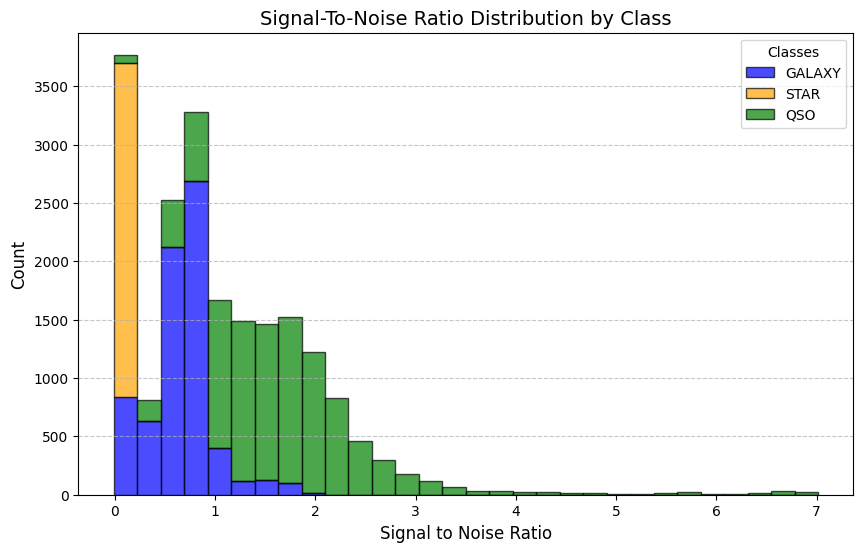

In [6]:
def plot_histogram(vals, bins=30):
    """
    Plots a stacked histogram of the redshift / signal-to-noise ratio (SNR) distribution for different classes.

    Args:
        vals (dict): A dictionary where the keys are class names (strings) and the values are lists of 
                           redshift / signal-to-noise ratio (SNR) values for each class.
        bins (int, optional): The number of bins to use in the histogram (default is 30).

    Returns:
        None: This function generates and displays the plot, but does not return any value.
    """
    # Prepare data and labels
    classes = list(vals.keys())
    data = [vals[cls] for cls in classes if len(vals[cls]) > 0]
    
    # Define colors for each class
    colors = ['blue', 'orange', 'green']
    
    # Create stacked histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, stacked=True, label=classes, color=colors, edgecolor="black", alpha=0.7)
    
    # Add labels and title
    plt.title('Signal-To-Noise Ratio Distribution by Class', fontsize=14)
    plt.xlabel('Signal to Noise Ratio', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title="Classes", fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()


redshift_data = analysis_data['redshifts'] 
plot_histogram(redshift_data)